In [1]:
from preamble import *

%config InlineBackend.figure_format = 'retina'
%load_ext lab_black

In [2]:
import sys, pandas

print("ABC version:", abc.__version__)
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)
print("Pandas version:", pandas.__version__)

tic()

ABC version: 0.1.0
Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Numpy version: 1.20.3
PyMC3 version: 3.11.2
Arviz version: 0.11.2
Pandas version: 1.2.4


In [3]:
numIters = 10
popSize = 1000
smcArgs = {"verbose": True, "numProcs": 40}

In [4]:
rg = default_rng(123)

sample_sizes = [50, 250]
T = sample_sizes[-1]

# Frequency-Loss Model
sigma = 0.2
w1 = 15
w2 = 5
m1 = 10
m2 = 40
θ_True = sigma, w1, w2, m1, m2

freq = "bivariate poisson"
sev = "exponential"

# Aggregation process
psi = abc.Psi("sum")

claimsData = abc.simulate_claim_data(rg, T, freq, sev, θ_True)

xData1 = abc.compute_psi(claimsData[0][0], claimsData[0][1], psi)
xData2 = abc.compute_psi(claimsData[1][0], claimsData[1][1], psi)

xData = (xData1, xData2)

In [5]:
prior = abc.IndependentUniformPrior([(0, 2), (0, 50), (0, 50), (0, 100), (0, 100)])
model = abc.Model("bivariate poisson", "exponential", psi, prior)

In [6]:
params = ("sigma", "w1", "w2", "m1", "m2")
dfABC = pd.DataFrame()

for ss in sample_sizes:
    xDataSS = np.vstack([xData1[:ss], xData2[:ss]]).T

    %time fit =  abc.smc(numIters, popSize, xDataSS, model, sumstats=abc.wass_2Ddist_ss, distance=abc.wass_2Ddist, **smcArgs)

    columns = {"ss": np.repeat(ss, popSize), "weights": fit.weights}
    for i, param in enumerate(params):
        columns[param] = fit.samples[:, i]

    res = pd.DataFrame(columns)

    dfABC = pd.concat([dfABC, res])

Final population dists <= 43.39, ESS = 416
CPU times: user 8.83 s, sys: 1.36 s, total: 10.2 s
Wall time: 15.2 s


Final population dists <= 43.81, ESS = 756
CPU times: user 9.15 s, sys: 907 ms, total: 10.1 s
Wall time: 27.1 s


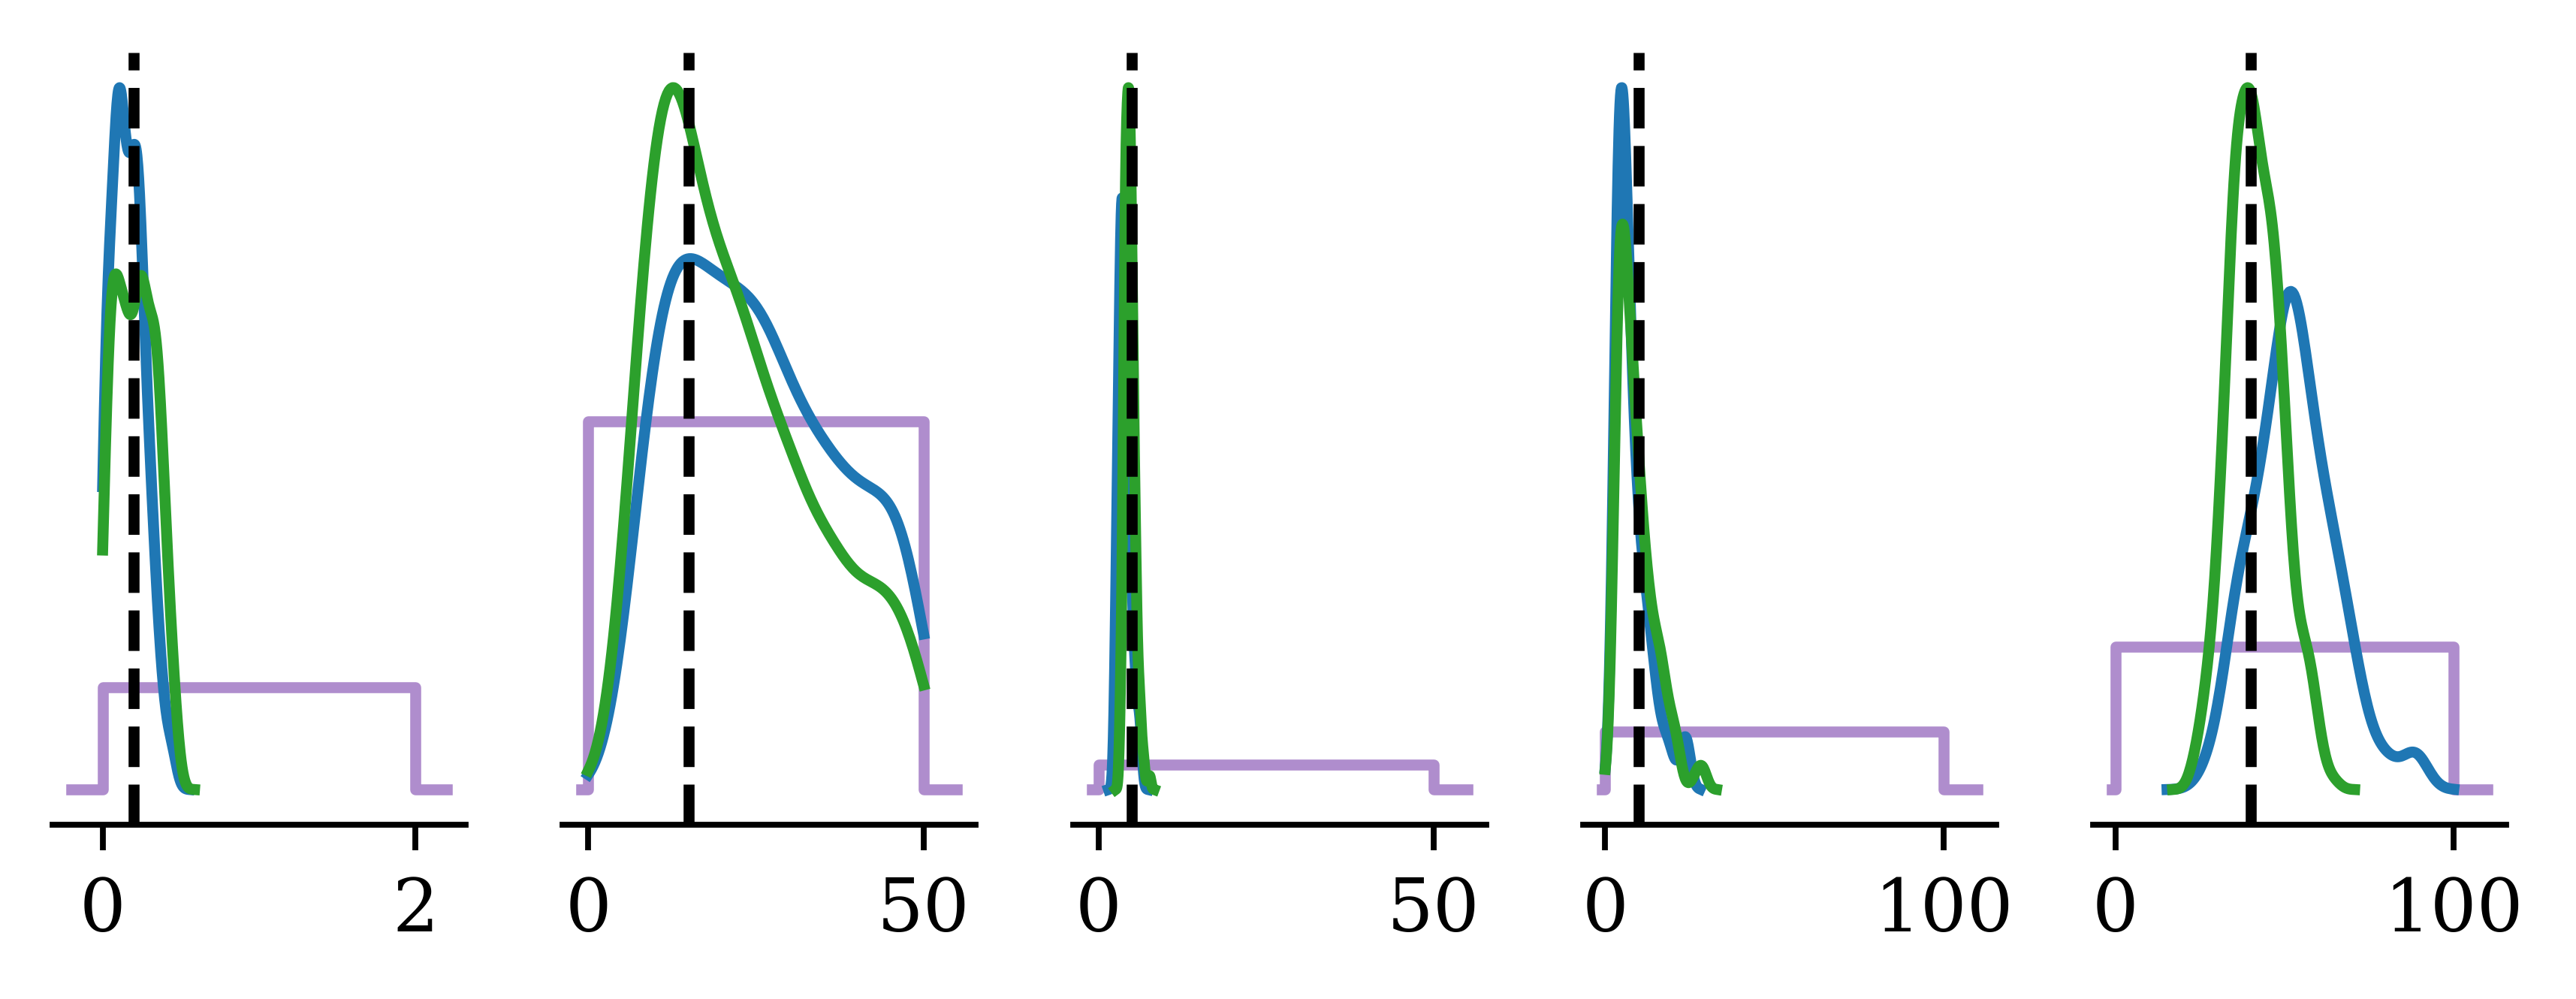

In [7]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_True[l], **trueStyle)
    #     axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-bivariate-poisson-exp.pdf")

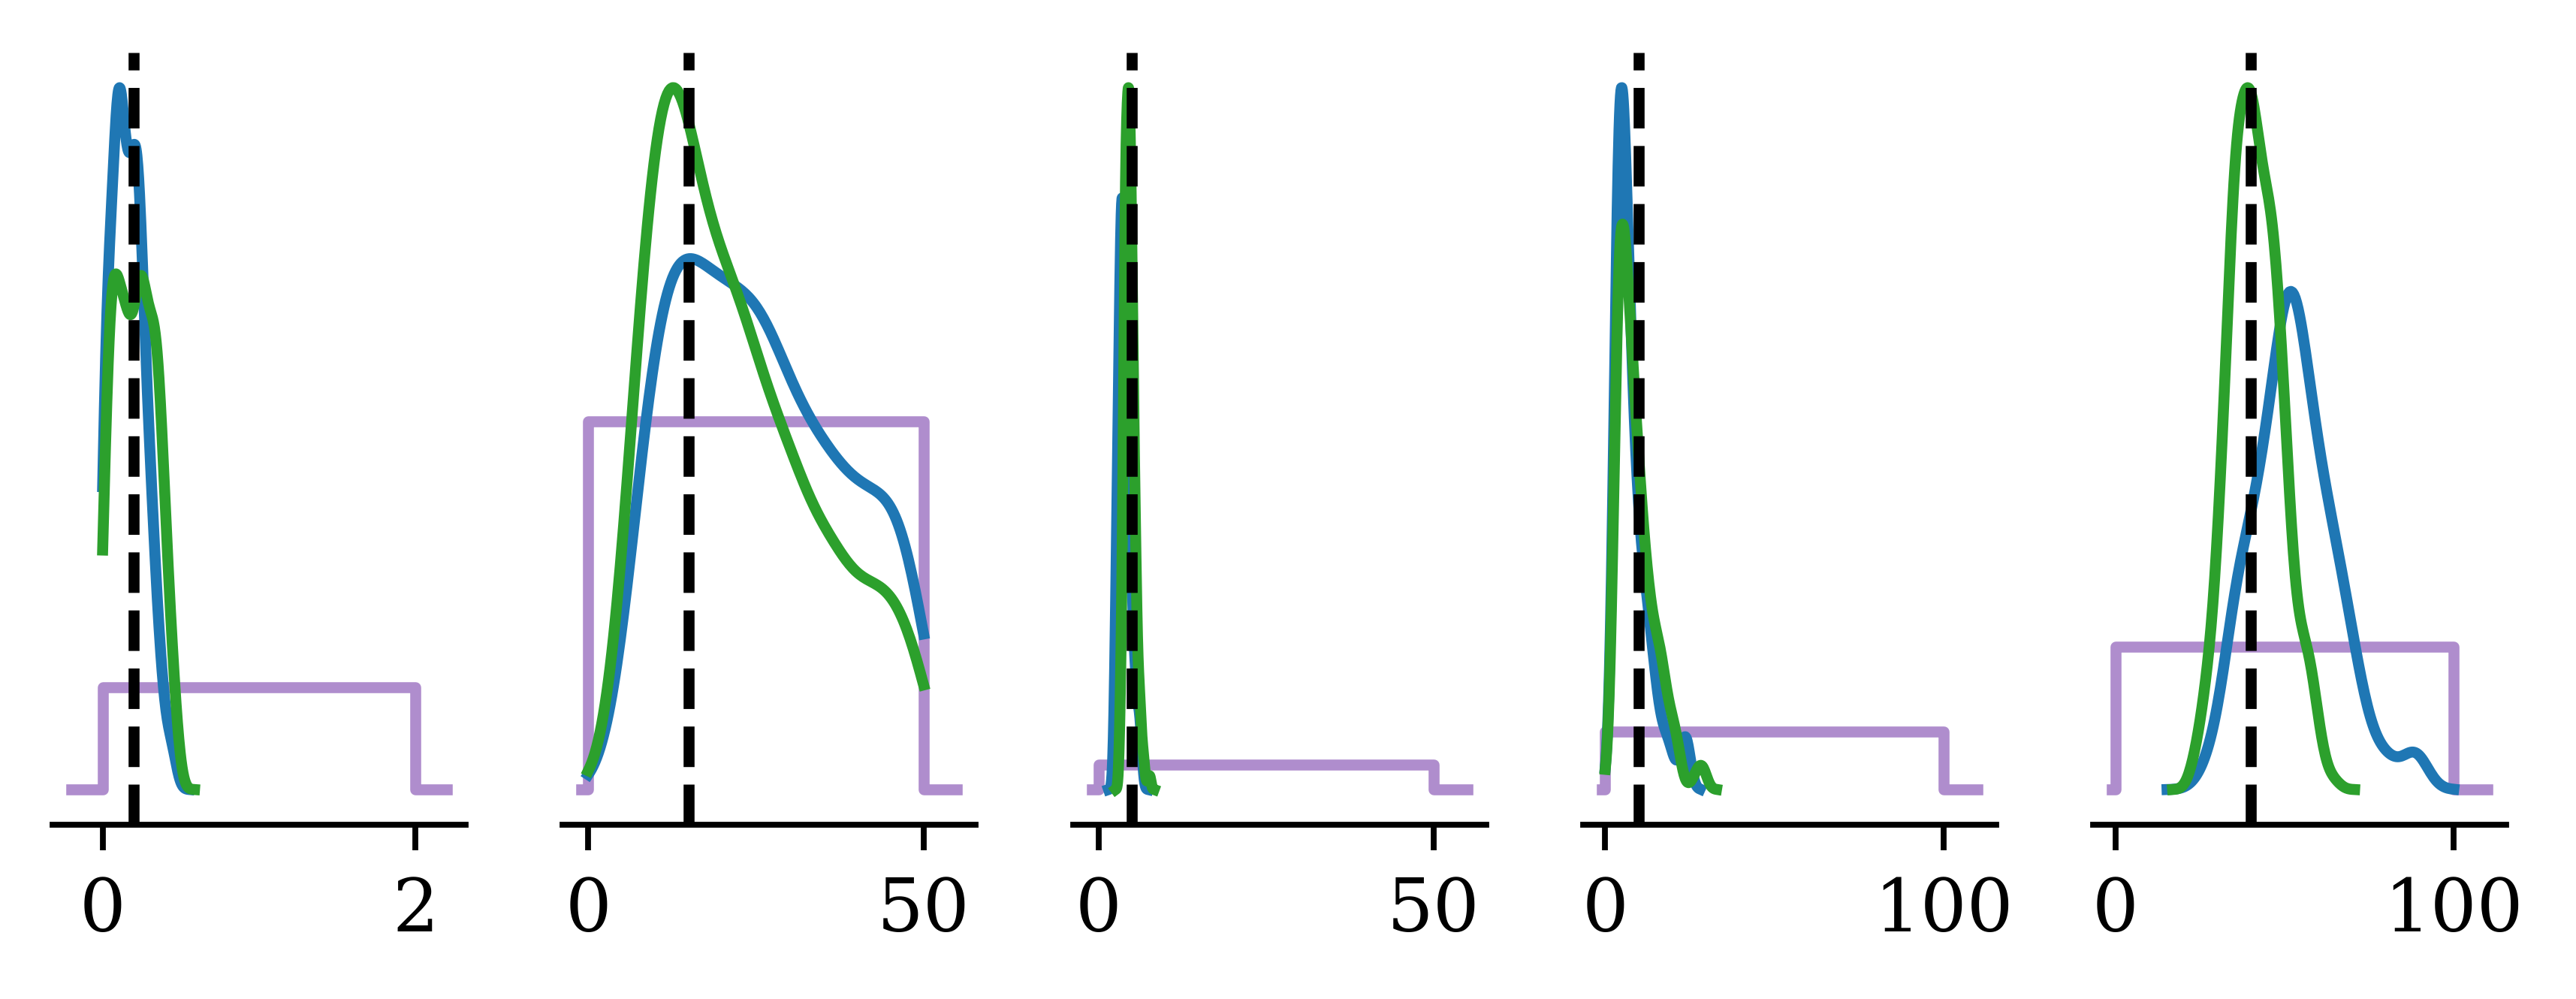

In [8]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_True[l], **trueStyle)
    #     axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-bivariate-poisson-exp.pdf")

In [9]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 46 secs = 0.77 mins


In [10]:
dill.dump_session("Sim_Bivariate_Poisson_Exp.pkl")